<a href="https://colab.research.google.com/github/palash-21/Rossmann_Stores_Sales_Prediction/blob/main/Rossmann_Stores_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 1 Lets equip all the necessary tools

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 2 Data Preparation 

## 2.1 Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_store_csv = "/content/drive/MyDrive/Colab Notebooks/almabetter pro materials/Capstone Projects/My Capstone Projects/Rossman stores sales prediction/store.csv"
store_df = pd.read_csv(path_store_csv)

path_sales_csv = "/content/drive/MyDrive/Colab Notebooks/almabetter pro materials/Capstone Projects/My Capstone Projects/Rossman stores sales prediction/Rossmann Stores Data.csv"
sales_df = pd.read_csv(path_sales_csv, parse_dates = ['Date'])
#sales_df = pd.read_csv(path_sales_csv)

#2.2  Data Cleaning

In [ ]:
# Taking a glance on the datasets
print("no of observations & no of features", sales_df.shape)
sales_df.head()

no of observations & no of features (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


Great!! There are no missing values here

In [ ]:
# Lets look at the dates
print('Start Date : ', sales_df['Date'].min(), '\n'
      'End Date : ', sales_df['Date'].max(),'\n'
      'Period of Days : ', sales_df['Date'].max() - sales_df['Date'].min())

Start Date :  2013-01-01 00:00:00 
End Date :  2015-07-31 00:00:00 
Period of Days :  941 days 00:00:00


So the dataset is for 942 days in total from 1st Jan 2013 to 31st July 2015

In [ ]:
# Grouping by date
sales_df.groupby(['Store'])['Date'].count().reset_index().groupby(['Date'])["Store"].count().reset_index().rename(columns={'Date':'Date_count',"Store":'Store_count'})

,Date_count,Store_count
0,758,180
1,941,1
2,942,934


So out of 1115 total stores we have store sales data of 934 stores for 942 days 
while for 180 stores we only have 758 days of sales data
As mentioned in the problem statement, stores may be  temporarily closed for refurbishment at the time

In [ ]:
# Lets look at the stores dataset
print("no of observations & no of features", store_df.shape)
store_df.head()

no of observations & no of features (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
#Counting missing values in the dataset

print('store_df :\n\n', store_df.isnull().sum())

store_df :

 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [ ]:
store_df['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

`Promo2SinceWeek` , `Promo2SinceYear` and `PromoInterval` are features giving information about Promo2 and null values corresponds to stores that are not participating in it. Lets take care of it later

We have 3 missing entries for distance to nearest competition, lets look at the feature distribution\

Text(0.5, 1.0, 'Distributin of Store Competition Distance')

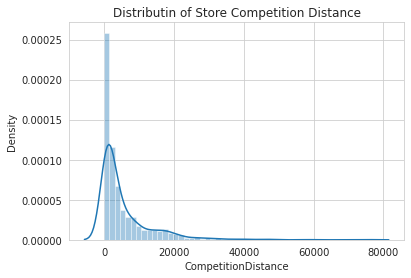

In [ ]:
# CompetitionDistance is distance in meters to the nearest competitor store
# Let's first have a look at its distribution
sns.distplot(store_df.CompetitionDistance)
plt.title("Distributin of Store Competition Distance")

Replacing the missing values with median would be a good choice

In [ ]:
# Replace missing values in CompetitionDistance with median for the store dataset
store_df.CompetitionDistance.fillna(store_df.CompetitionDistance.median(), inplace=True)


Out of 1115 stores, for 354 stores we dont have information about the age of nearest competitive store.
Lets generate a new feature indicating the age of competition in terms of months while for null values we will replace it with 0.
To execute this , we need to first merge both the dfs.

In [ ]:
# Lets merge both the files
df=pd.merge(sales_df,store_df,how='left',on='Store')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
# Lets get year, month, date from current date

def GetYear(date):
  return date.year

def GetMonth(date):
  return date.month

def GetDay(date):
  return date.day



df['Year'] = df['Date'].apply(GetYear)
df['Month'] = df['Date'].apply(GetMonth)
df['Day'] = df['Date'].apply(GetDay)

In [ ]:
# Function to get competition age
def GetCompetitionAge(year,month,date):

  #Initiating with a variable for age
  age=0

  # Comparing the Competition open time with current time
  if date.year>year:
    age+= (date.year-year)*12 + (date.month - month)

  elif date.year == year and date.month>month:
    age+= date.month - month

  return age

In [ ]:
df['CompetitionAge'] = df.apply(lambda x: GetCompetitionAge(x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth,x.Date), axis=1)

In [ ]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,CompetitionAge
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,3.0


In [ ]:
# Lets look at promo2
df['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [ ]:
# There are 3 types of intervals followed by different stores indicating the month in which promo2 new rounf is started
# Lets generate a binary variable showing if new promo2 round is started in the current month or not

# String to List
df['PromoInterval'] = df['PromoInterval'].str.split(',')  

# Converting months into list of month numbers for easy comparison
def GetMonthNumber(month):
  month_dict = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sept':9,'Oct':10,'Nov':11,'Dec':12}
  return month_dict[month]

def GetNumList(interval):
  numlist=[]
  for month in interval:
    month_num = GetMonthNumber(month)
    numlist.append(month_num)
  return numlist  

In [ ]:
print(df['PromoInterval'][1], '\n' ,
      GetNumList(df['PromoInterval'][1]))

['Jan', 'Apr', 'Jul', 'Oct'] 
 [1, 4, 7, 10]


In [ ]:
# Function to check promo2 new round

def IsPromo2NewRound(promo_part,promo_year,promo_week,promo_interval,date):

  # Initiating a variable if promo is active
  promo_active = 0
  # Initiating a variable if promo new round is active
  promo_new= 0

  # Taking only stores that are participating in promo2
  if promo_part == 1:
    # Checking if the promo has been activated
    if date.year == promo_year and date.week >= promo_week :
      promo_active = 1

    elif date.year > promo_year :
      promo_active = 1

    if promo_active == 1:
      
      #Getting month_number for easy comparison
      promo_months = GetNumList(promo_interval)
      #Checking if new round is started in current month
      if date.month in promo_months:
        promo_new = 1

  return promo_new

In [ ]:
df['Promo2New'] = df.apply( lambda x : IsPromo2NewRound(x.Promo2,x.Promo2SinceYear,x.Promo2SinceWeek,x.PromoInterval,x.Date),axis=1)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,CompetitionAge,Promo2New
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,82.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"[Jan, Apr, Jul, Oct]",2015,7,31,92.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]",2015,7,31,103.0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,70.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,3.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

All null values are dealt with..
One step remains before we move on to EDA

#2.3 Sanity check

In [ ]:
df.dropna(axis=1).describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,Day,CompetitionAge,Promo2New
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.422021e+03,5.005638e-01,2.013832e+03,5.846762e+00,1.570279e+01,4.203993e+01,1.493892e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.706918e+03,4.999999e-01,7.773960e-01,3.326097e+00,8.787638e+00,6.534447e+01,3.564718e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,0.000000e+00,2.013000e+03,3.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.325000e+03,1.000000e+00,2.014000e+03,6.000000e+00,1.600000e+01,1.600000e+01,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.880000e+03,1.000000e+00,2.014000e+03,8.000000e+00,2.300000e+01,7.300000e+01,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,1.000000e+00,2.015000e+03,1.200000e+01,3.100000e+01,1.386000e+03,1.000000e+00


In [ ]:
# Stateholiday dtype is object, lets check why
df['StateHoliday'].value_counts()


0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [ ]:
# Converting all number 0 to string '0' for no holiday
df['StateHoliday'][df['StateHoliday']==0] = '0'

In [ ]:
df['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [ ]:
# Store open/close
df[df['Open']==0][['Sales','Customers','StateHoliday','SchoolHoliday']].value_counts()

Sales  Customers  StateHoliday  SchoolHoliday
0      0          0             0                139610
                  a             0                 14465
                  b             1                  6067
                  a             1                  5101
                  c             1                  4029
                  0             1                  3067
                  b             0                   478
dtype: int64

In [ ]:
# Check entries for which Sales is zero
df[df['Sales']==0][["Open",'Customers','StateHoliday','SchoolHoliday']].value_counts()

Open  Customers  StateHoliday  SchoolHoliday
0     0          0             0                139610
                 a             0                 14465
                 b             1                  6067
                 a             1                  5101
                 c             1                  4029
                 0             1                  3067
                 b             0                   478
1     0          0             0                    40
                               1                    12
      3          0             0                     1
      5          0             0                     1
dtype: int64

1.   Store are closed even when there is no state or school holiday, this may be for refurbishment as mentioned in the problem statement
2.   Sales is zero for some entries even when store is open , this may cause bias in model so we should remove this as we dont want our model to predict zero sales for any store

In [ ]:
df.drop(df[(df['Sales']==0) & (df['Open']==1)].index,inplace=True)

In [ ]:
df.shape

(1017155, 23)

#3 Exploratory Data Analysis

In [ ]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,CompetitionAge,Promo2New
count,1.017155e+06,1.017155e+06,1.017155e+06,1.017155e+06,1.017155e+06,1.017155e+06,1.017155e+06,1.017155e+06,693826.000000,693826.000000,1.017155e+06,509139.000000,509139.000000,1.017155e+06,1.017155e+06,1.017155e+06,1.017155e+06,1.017155e+06
mean,5.584284e+02,3.998356e+00,5.774126e+03,6.331796e+02,8.300977e-01,3.815141e-01,1.786444e-01,5.422165e+03,7.222835,2008.690232,5.005520e-01,23.269714,2011.752700,2.013832e+03,5.846792e+00,1.570280e+01,4.204004e+01,1.493853e-01
std,3.219078e+02,1.997420e+00,3.849799e+03,4.644012e+02,3.755472e-01,4.857585e-01,3.830544e-01,7.707027e+03,3.211810,5.992658,4.999999e-01,14.096037,1.662857,7.774051e-01,3.326120e+00,8.787591e+00,6.534467e+01,3.564680e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.728000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,2.013000e+03,3.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.325000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,2.014000e+03,6.000000e+00,1.600000e+01,1.600000e+01,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.880000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,2.014000e+03,8.000000e+00,2.300000e+01,7.300000e+01,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000,2.015000e+03,1.200000e+01,3.100000e+01,1.386000e+03,1.000000e+00


In [ ]:
# Only when store is open
df_open = df[df['Open']==1]
df_open.drop(columns=["Open"],inplace=True)

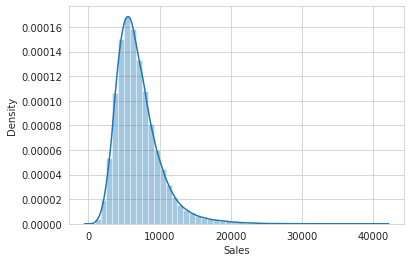

In [ ]:
# Lets look at our dependant variable
sns.distplot(df_open['Sales'])

There is positive skewness, so we should use transformation before training our model

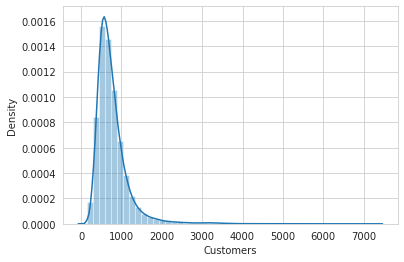

In [ ]:
# Customers
sns.distplot(df_open['Customers'])

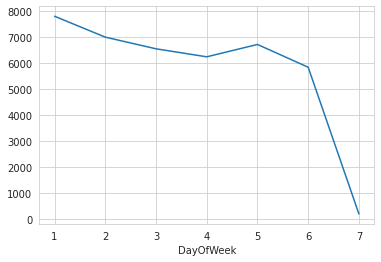

In [ ]:
# Week-days-wise average sales
df.groupby('DayOfWeek')['Sales'].mean().plot()

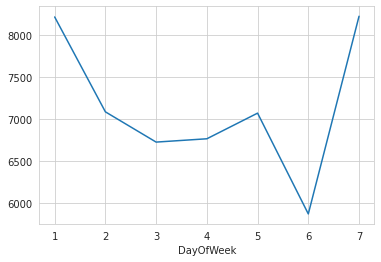

In [ ]:
# Week-days-wise average sales only when store is open
df_open.groupby('DayOfWeek')['Sales'].mean().plot()

As it is evident from the entries day 1 is Monday.

While stores are mostly closed on sundays, sales is highest when open.

Apart from sunday, sale is maximum on Mondays

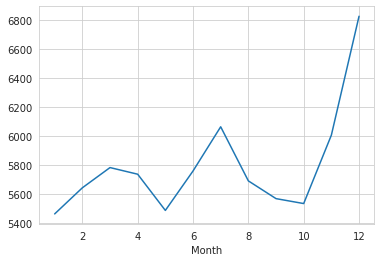

In [ ]:
# Monthly Average Sales
# As we dont have data for 2015 whole year, sum of sales wont be the correct statistic, lets take average. 
df.groupby('Month')['Sales'].mean().plot()

Towards year ending sales are better on an average 

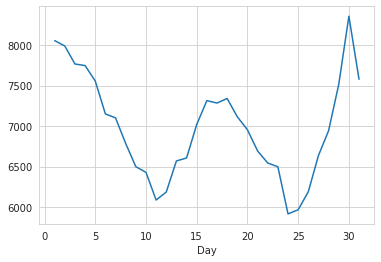

In [ ]:
# Date of the month vs Sales
df_open.groupby('Day')['Sales'].mean().plot()

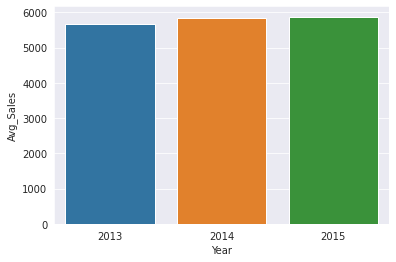

In [ ]:
# Year vs sales(average)
temp_df = df.groupby([df.Year])['Sales'].mean().reset_index()
temp_df.rename(columns={'Sales':'Avg_Sales'},inplace=True)
x=temp_df['Year']
y=temp_df['Avg_Sales']
sns.set_style("darkgrid")
sns.barplot(x=x,y=y)
plt.show()

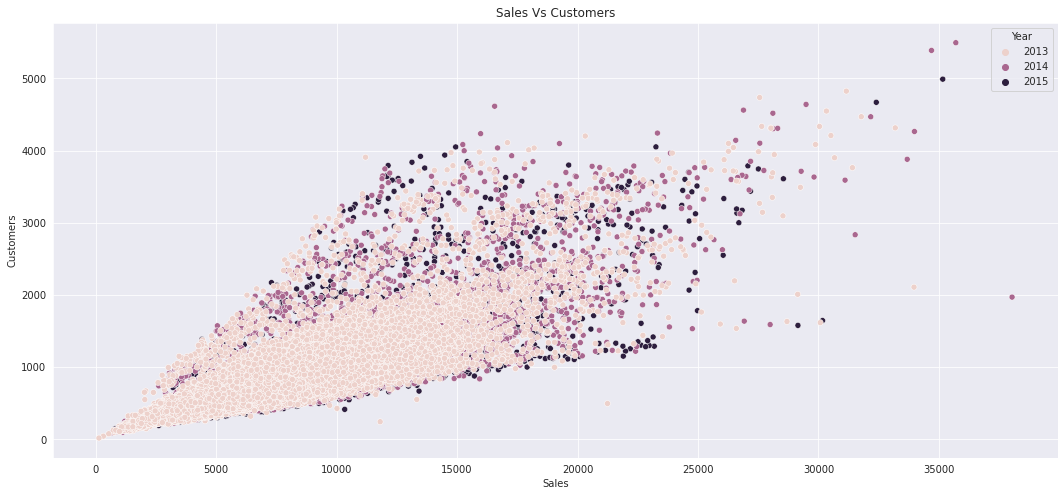

In [ ]:
# Sales vs customers
plt.figure(figsize=(18,8))
temp_df = df_open.sample(100000)
sns.scatterplot(temp_df.Sales, temp_df.Customers, hue=df.Year)
plt.title("Sales Vs Customers")
plt.show()

In [ ]:
store_df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

Text(0.5, 1.0, 'Number of stores running promo')

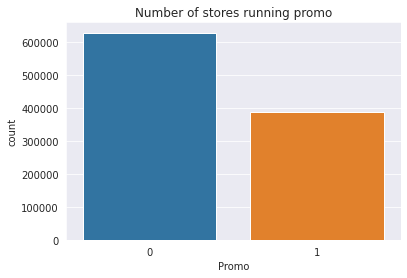

In [ ]:
# Number of stores running promo
sns.countplot(x=sales_df['Promo']).set_title('Number of stores running promo')

Stores are not running promo for majority of days

[Text(0.5, 1.0, 'Sales vs Promo')]

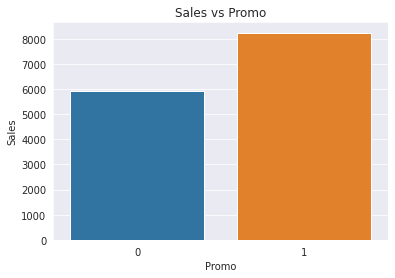

In [ ]:
# Lets see how promo is impacting sales
sns.barplot(x='Promo',y='Sales',data=df_open).set(title='Sales vs Promo')

It is evident that promo is effective

Text(0.5, 1.0, 'Number of stores running promo2')

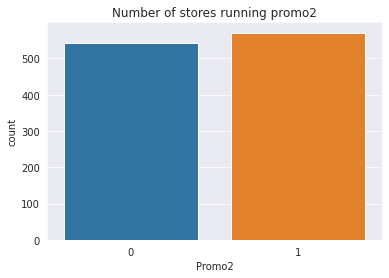

In [ ]:
# Number of stores participating in promo2
sns.countplot(x=store_df['Promo2']).set_title('Number of stores running promo2')

More than 50% of stores are participating in Promo2

[Text(0.5, 1.0, 'Sales vs Promo2new')]

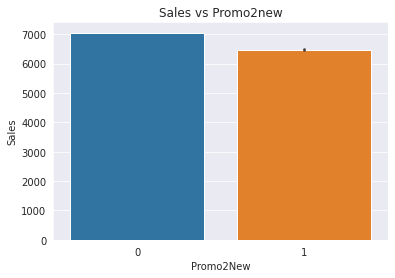

In [ ]:
# Effect on sales when new promo2 is started 
sns.barplot(x='Promo2New',y='Sales',data=df_open).set(title='Sales vs Promo2new')

Promo 2 is ineffective

In [ ]:
# Lets look at the storetype
store_df["StoreType"].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

So, majority of stores are of 'a' type , followed by d and c while b type are the least 

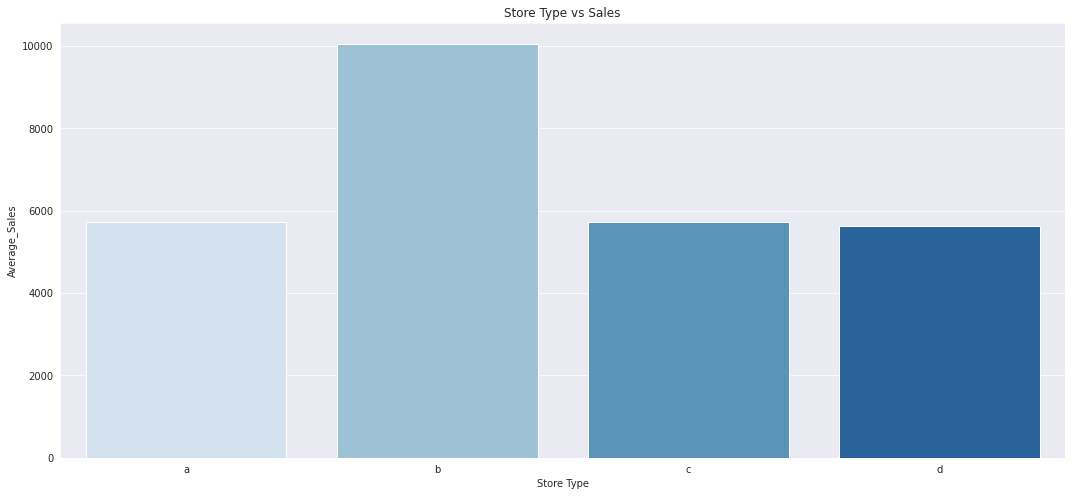

In [ ]:
# Store type
plt.figure(figsize=(18,8))
temp_df = df.groupby(df.StoreType).mean()
sns.barplot(temp_df.index, temp_df.Sales, palette='Blues')
plt.title("Store Type vs Sales")
plt.xlabel('Store Type')
plt.ylabel('Average_Sales')
plt.show()

Store b are the least in numbers but on an average outperforms other store types
Lets check if the reason is promo or competition

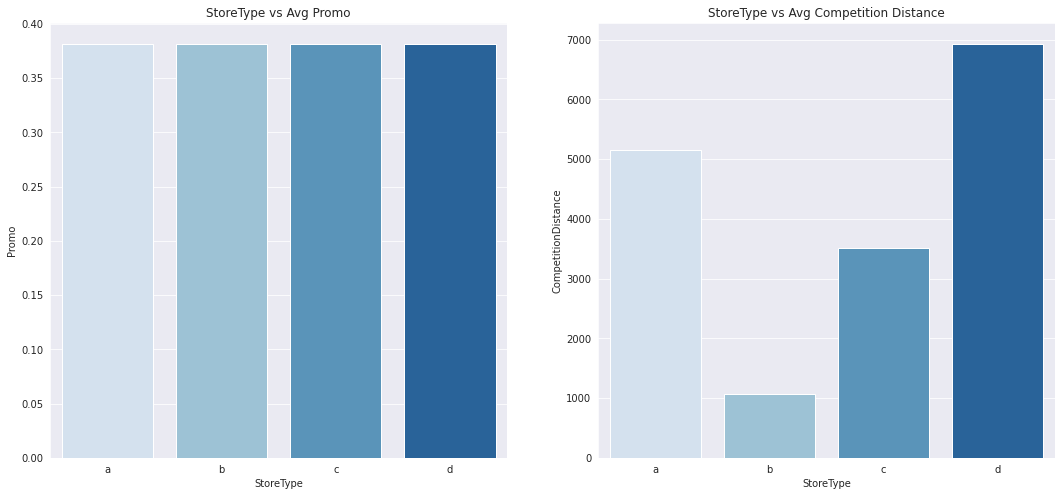

In [ ]:
# Store type and competition
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.groupby(df.StoreType).mean()
sns.barplot(temp_df.index, temp_df['Promo'], ax=ax1, palette='Blues').set(title='StoreType vs Avg Promo')
temp_df = df.groupby(df.StoreType).mean()
sns.barplot(temp_df.index, temp_df['CompetitionDistance'], ax=ax2, palette='Blues').set(title='StoreType vs Avg Competition Distance')
plt.show()

Store type b has the least competition , meaning distance from the nearest competition is the lowest on an average for store type b which lead to higher sales on an average.



In [ ]:
# Assortment level of stores
store_df['Assortment'].value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

[Text(0.5, 1.0, 'Avg Sales vs Assortment Level')]

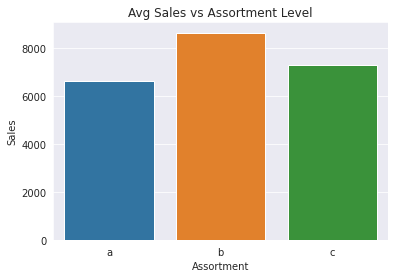

In [ ]:
# Sales vs Assortment Type
temp_df=pd.DataFrame(df_open.groupby('Assortment')['Sales'].mean())
sns.barplot(temp_df.index, temp_df.Sales).set(title='Avg Sales vs Assortment Level')
#temp_df

Assortement level indicates a = basic, b = extra, c = extended
So, extra level has highest average sales

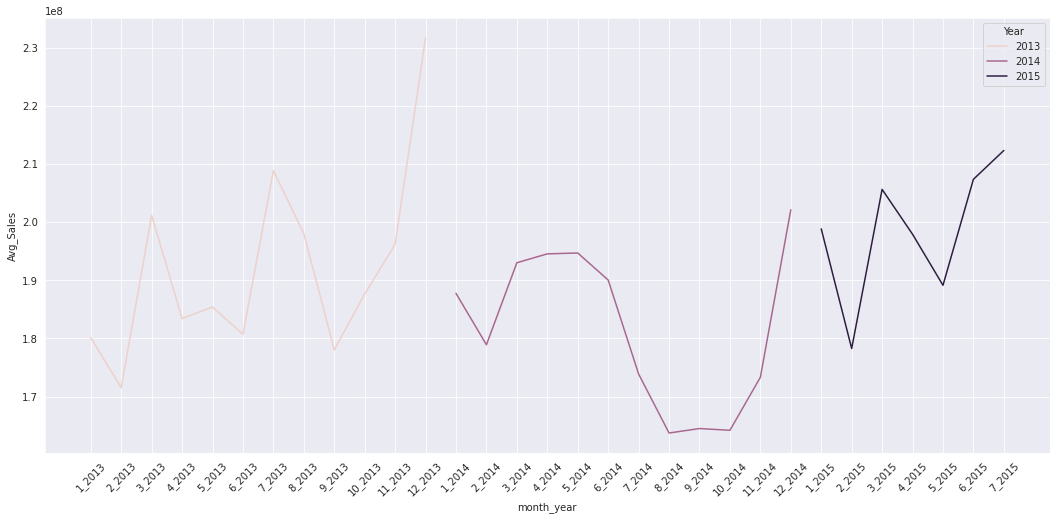

In [ ]:
# Sales trend
temp_df = df_open.groupby([(df.Year),(df.Month)])['Sales'].sum().reset_index()
temp_df.rename(columns={'Sales':'Avg_Sales'},inplace=True)
temp_df['month_year'] = temp_df['Month'].astype(str) + '_' + temp_df['Year'].astype(str)

plt.figure(figsize=(18,8))
x=temp_df['month_year']
y=temp_df['Avg_Sales']
sns.lineplot(x=x,y=y,hue=temp_df['Year'])
plt.xticks(rotation=45)
plt.show()
#temp_df

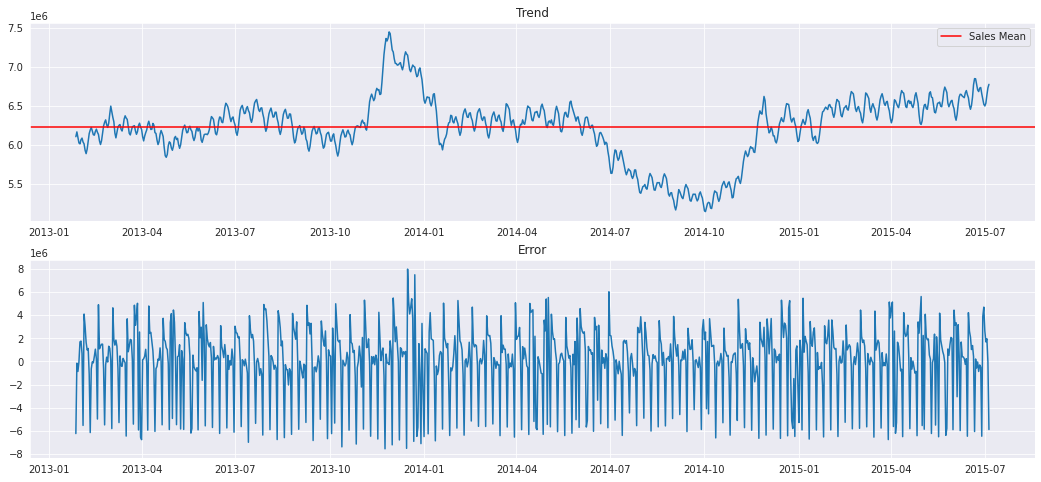

In [ ]:
# Lets look at the trend and seasonal part
from statsmodels.tsa.seasonal import seasonal_decompose
temp_df = df_open.copy()
temp_df.Date = pd.to_datetime(temp_df.Date)
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df[['Sales']]
temp_df = temp_df.groupby(temp_df.index).sum()
result = seasonal_decompose(temp_df, model='additive', freq=52)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
ax1.plot(result.trend)
ax1.axhline(y = temp_df.Sales.mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Trend")
ax2.plot(result.resid)
ax2.set_title("Error")
ax1.legend()
plt.show()

2015 seems to be a good year as the trend line is above the average trend line.

There is a peak at end of 2013 and a dip in year 2014 from July-Oct

I wonder what drived that?

In [ ]:
# First lets check the number of stores open 
temp_df = pd.DataFrame()
temp_df['2013']= df[df['Year']==2013].groupby('Month')["Open"].sum()
temp_df['2014']= df[df['Year']==2014].groupby('Month')["Open"].sum()
temp_df['2015']= df[df['Year']==2015].groupby('Month')["Open"].sum()
temp_df

,2013,2014,2015
Month,,,
1,28865,28707,28763.0
2,26682,26791,26766.0
3,27891,29005,29079.0
4,27878,26917,26931.0
5,26199,28021,25879.0
6,27939,26209,28423.0
7,30164,25224,30188.0
8,30023,24388,NaN
9,27980,24341,NaN


Many of the storee where closed in 2nd half of 2014 that lead to dip in sales

Stores may be closed for refurbishment 

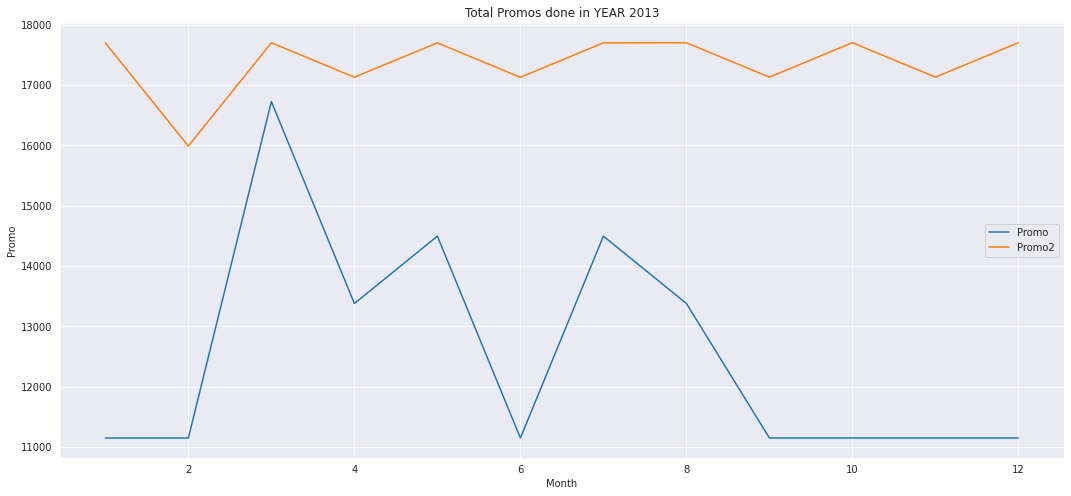

In [ ]:
# Promos done in year 2013
plt.figure(figsize=(18,8))
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df= temp_df[temp_df.Year==2013]
temp_df = temp_df.groupby(temp_df.Month).sum()


plt.title('Total Promos done in YEAR 2013')
sns.lineplot(temp_df.index, temp_df.Promo,palette='Blues',label='Promo')
sns.lineplot(temp_df.index, temp_df.Promo2, palette='Blues', label='Promo2')
plt.legend()
plt.show()
#temp_df.head()

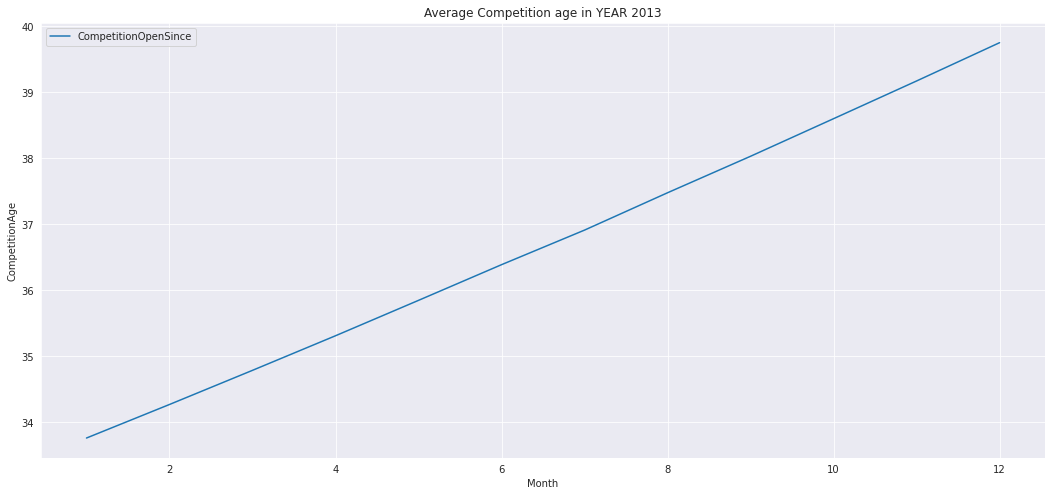

In [ ]:
# Lets check if there is any entry of new competition
plt.figure(figsize=(18,8))
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df= temp_df[temp_df.Year==2013]
temp_df = temp_df.groupby(temp_df.Month).mean()


plt.title('Average Competition age in YEAR 2013')
sns.lineplot(temp_df.index, temp_df.CompetitionAge,palette='Blues',label='CompetitionOpenSince')
plt.legend()
plt.show()

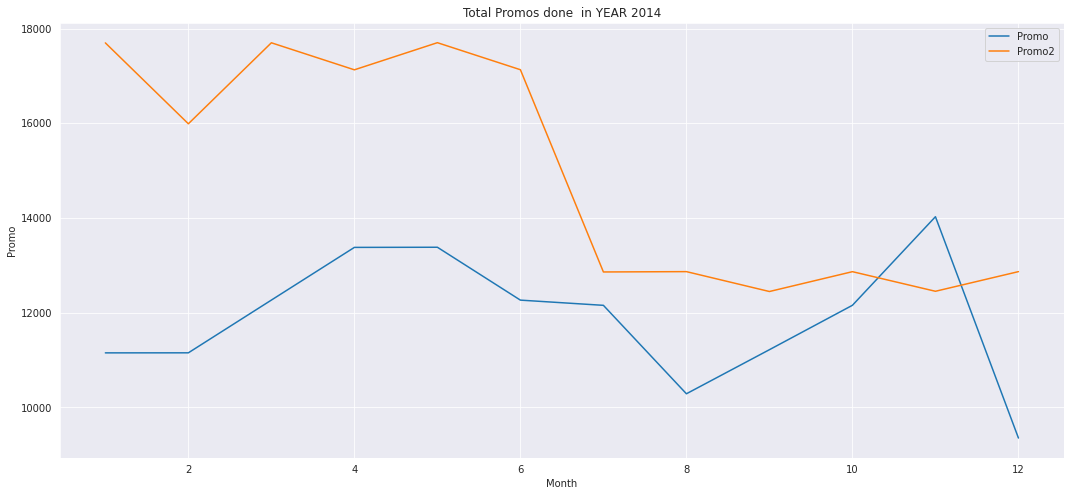

In [ ]:
# Promos done in year 2014
plt.figure(figsize=(18,8))
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df= temp_df[temp_df.Year==2014]
temp_df = temp_df.groupby(temp_df.Month).sum()


plt.title('Total Promos done  in YEAR 2014')
sns.lineplot(temp_df.index, temp_df.Promo,palette='Blues',label='Promo')
sns.lineplot(temp_df.index, temp_df.Promo2, palette='Blues', label='Promo2')
plt.legend()
plt.show()
#temp_df.head()

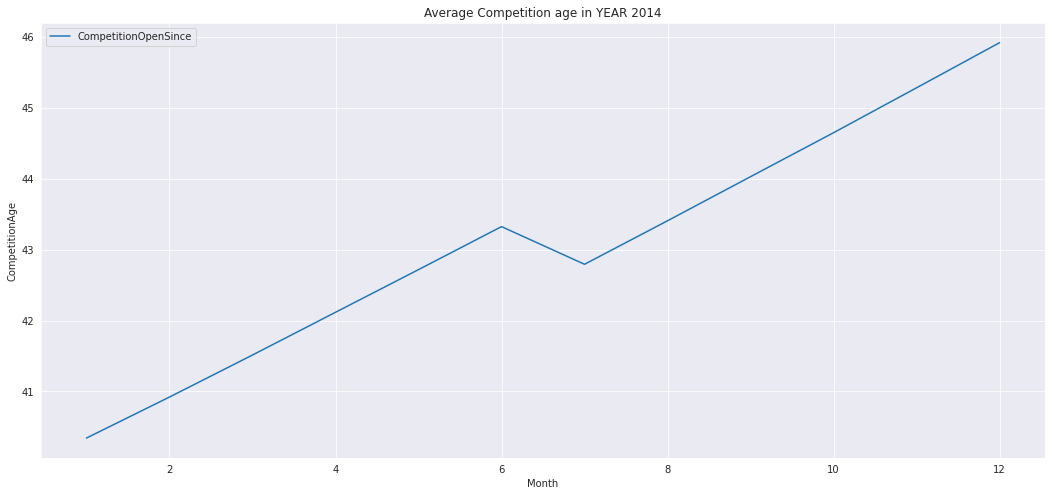

In [ ]:
# Lets check if there is any entry of new competition
plt.figure(figsize=(18,8))
temp_df = df.copy()
temp_df.index = temp_df.Date
temp_df= temp_df[temp_df.Year==2014]
temp_df = temp_df.groupby(temp_df.Month).mean()


plt.title('Average Competition age in YEAR 2014')
sns.lineplot(temp_df.index, temp_df.CompetitionAge,palette='Blues',label='CompetitionOpenSince')
plt.legend()
plt.show()

Stores have decreased promo participation after june 2014 and also there is new entry in competition which may also have fatored in the dip in sales

[Text(0.5, 1.0, 'Avg Sales vs StateHoliday')]

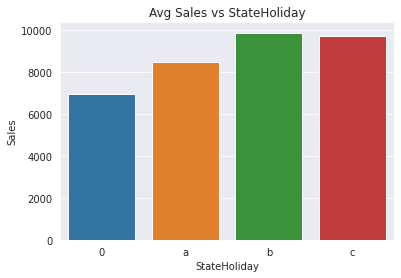

In [ ]:
# Stateholiday vs Sales
temp_df=pd.DataFrame(df_open.groupby('StateHoliday')['Sales'].mean())
sns.barplot(temp_df.index, temp_df.Sales).set(title='Avg Sales vs StateHoliday')
#temp_df

Ss we already know that a = public holiday, b = Easter holiday, c = Christmas  so sales are maximum on Easter holiday on an average followed by Christmas while on a regular day sales are low ( on average)

[Text(0.5, 1.0, 'School Holiday vs Sales')]

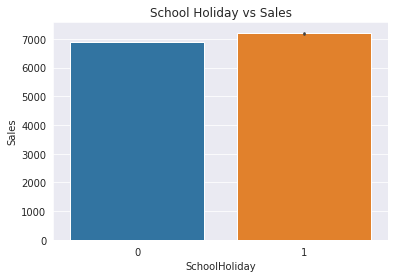

In [ ]:
# Sales vs School Holiday
sns.barplot(x='SchoolHoliday', y='Sales', data=df_open).set(title='School Holiday vs Sales')

Sales are higher on school holidays

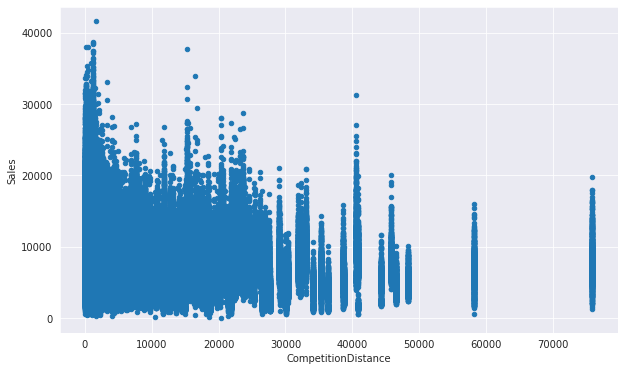

In [ ]:
# Competetion distance
df_open.plot(x='CompetitionDistance',y='Sales',kind='scatter',figsize =(10,6))

There is no major effect of competition distance on sales as even with less competition distance, there is no decrease in sales


In [ ]:
# Weekly trend check for multiple weeks by taking a sample

In [ ]:
# Predict if Stores are open/close on holidays


#4 Features

In [ ]:
# Making a copy of df
df1 = df.copy()

In [ ]:
df1['CompetitionAge'].describe()

count    1.017155e+06
mean     4.204004e+01
std      6.534467e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.600000e+01
75%      7.300000e+01
max      1.386000e+03
Name: CompetitionAge, dtype: float64

In [ ]:
df1['CompetitionAge'] = np.round(df1['CompetitionAge']/12,2)
df1['CompetitionAge'].describe()

count    1.017155e+06
mean     3.503320e+00
std      5.445394e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.330000e+00
75%      6.080000e+00
max      1.155000e+02
Name: CompetitionAge, dtype: float64

In [ ]:
# One hot encoding for categorical features
df1=pd.concat([df1,pd.get_dummies(df1['StateHoliday'],prefix='holy')],axis=1).drop(['StateHoliday'],axis=1)
# For stateholiday, we only need dummies for 3 holidays( public,easter & christmas ), so we can remove the holiday 0 dummy as in for no holiday
#df1.drop(columns=['holy_0'],inplace=True)
df1=pd.concat([df1,pd.get_dummies(df1['StoreType'],prefix='type')],axis=1).drop(['StoreType'],axis=1)
df1=pd.concat([df1,pd.get_dummies(df1['Assortment'],prefix='assort')],axis=1).drop(['Assortment'],axis=1)
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,CompetitionAge,Promo2New,holy_0,holy_a,holy_b,holy_c,type_a,type_b,type_c,type_d,assort_a,assort_b,assort_c
0,1,5,2015-07-31,5263,555,1,1,1,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,6.83,0,1,0,0,0,0,0,1,0,1,0,0
1,2,5,2015-07-31,6064,625,1,1,1,570.0,11.0,2007.0,1,13.0,2010.0,"[Jan, Apr, Jul, Oct]",2015,7,31,7.67,1,1,0,0,0,1,0,0,0,1,0,0
2,3,5,2015-07-31,8314,821,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]",2015,7,31,8.58,1,1,0,0,0,1,0,0,0,1,0,0
3,4,5,2015-07-31,13995,1498,1,1,1,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,5.83,0,1,0,0,0,0,0,1,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,1,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,0.25,0,1,0,0,0,1,0,0,0,1,0,0


In [ ]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'CompetitionAge', 'Promo2New', 'holy_0', 'holy_a', 'holy_b', 'holy_c',
       'type_a', 'type_b', 'type_c', 'type_d', 'assort_a', 'assort_b',
       'assort_c'],
      dtype='object')

In [ ]:
# Number of Customers will not be available for predictions, so we cannot use it for training
# Also removing all features that are not useful any more
df1.drop(columns =['Customers','CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'], inplace=True) 

In [ ]:
# We have zero sales for days when store is closed, so we will use it directy to get future predictions by predicting if store will remain open/close
# So we will not use this feature in our regression model
df1_open = df1[df1['Open']==1]
df1_open.drop(columns=['Open'],inplace=True)

In [ ]:
all_features = set(df1_open.drop(columns=["Date"]).columns) 
categorical_features = {'type_a', 'type_b', 'type_c', 'type_d', 'assort_a', 'assort_b' ,'assort_c','holy_0' ,'holy_a', 'holy_b', 'holy_c'}
numerical_features = all_features - categorical_features
print('Numerical Features :',numerical_features ,'\n'
      'Categorical Features :' , categorical_features)                       

Numerical Features : {'Sales', 'Year', 'Month', 'Store', 'Day', 'DayOfWeek', 'CompetitionDistance', 'Promo', 'SchoolHoliday', 'CompetitionAge', 'Promo2', 'Promo2New'} 
Categorical Features : {'assort_b', 'assort_a', 'holy_a', 'assort_c', 'type_c', 'type_b', 'type_d', 'holy_b', 'holy_c', 'holy_0', 'type_a'}


#4.3 Multi-collinearity & Skewness

In [ ]:
corr=df1_open.drop(columns=["Date"]).corr()
corr['Sales']

Store                  0.007723
DayOfWeek             -0.178753
Sales                  1.000000
Promo                  0.368199
SchoolHoliday          0.038635
CompetitionDistance   -0.035908
Promo2                -0.127556
Year                   0.036151
Month                  0.073589
Day                   -0.051865
CompetitionAge        -0.003200
Promo2New             -0.065465
holy_0                -0.019606
holy_a                 0.014152
holy_b                 0.012380
holy_c                 0.008237
type_a                -0.010591
type_b                 0.144685
type_c                -0.002891
type_d                -0.028627
assort_a              -0.113710
assort_b               0.053841
assort_c               0.103257
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Correlation Heatmap')

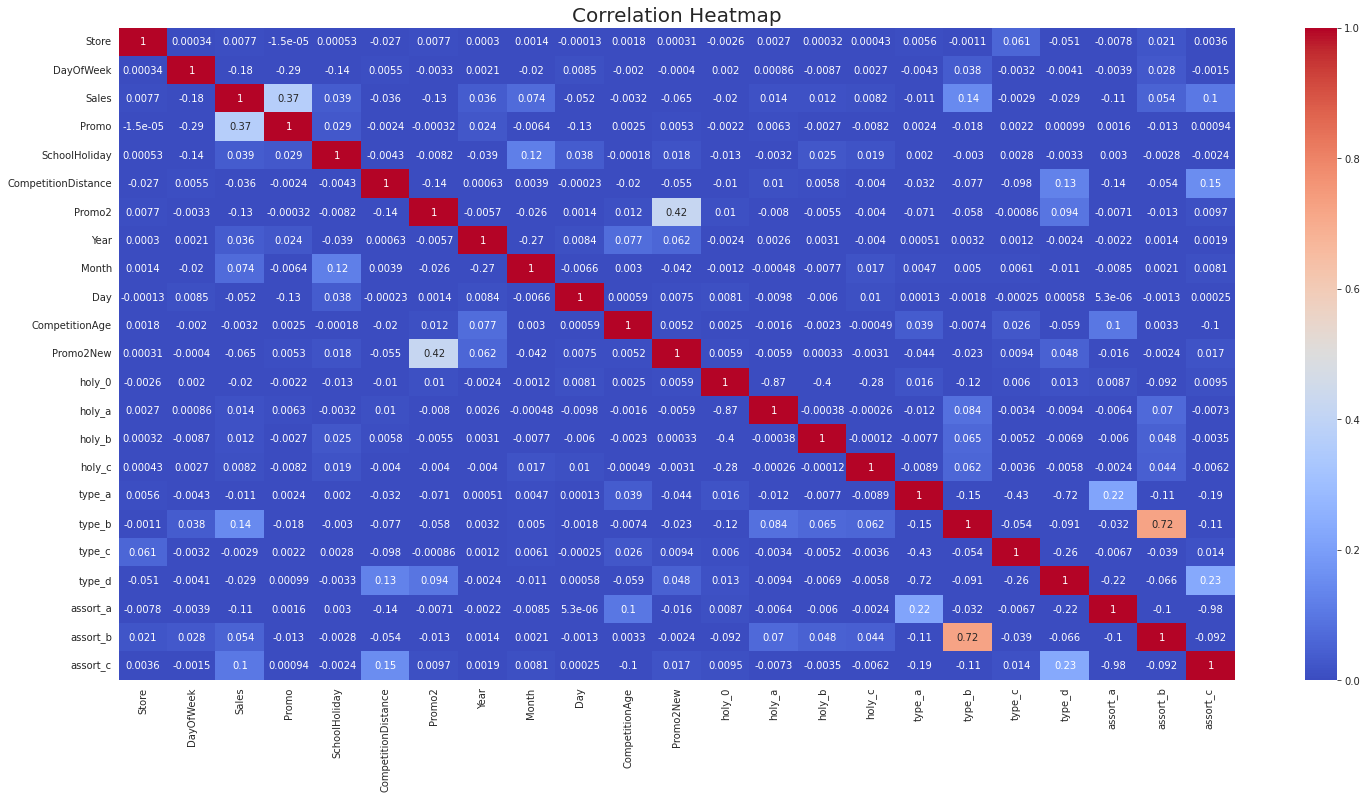

In [ ]:
# Heatmap
f,ax = plt.subplots(figsize = (25,12))
sns.heatmap(corr,vmin=0,annot=True,cmap='coolwarm')
plt.title("Correlation Heatmap", fontsize=20)

From the heatmap, we can breifly comment that important features apart from 'open' are promo, type_b(store_type),assortment c

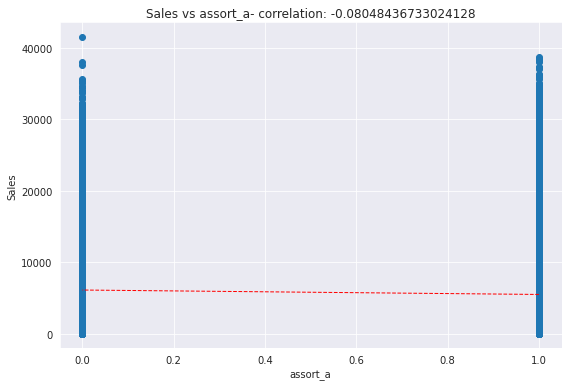

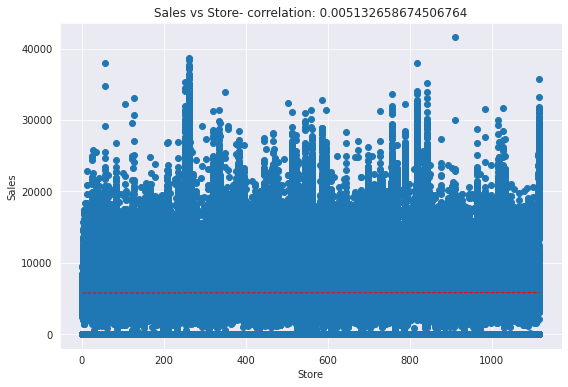

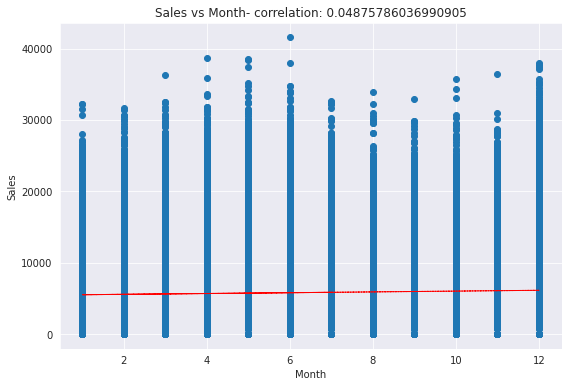

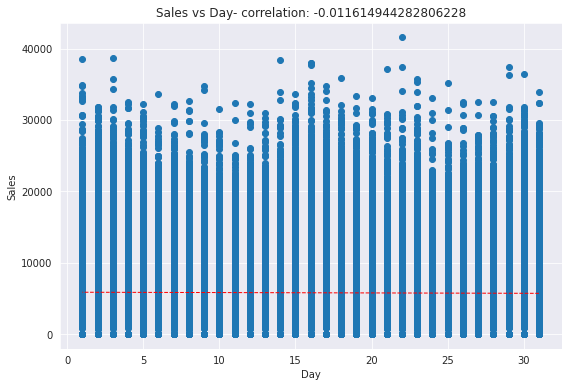

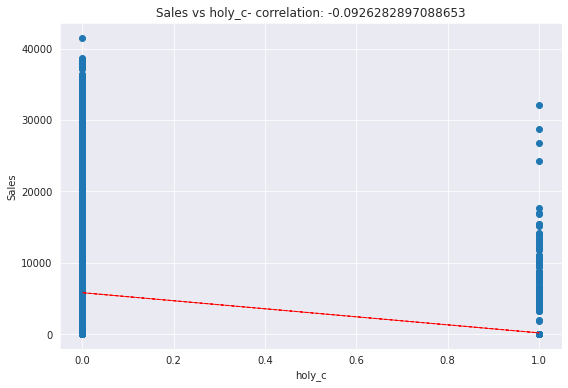

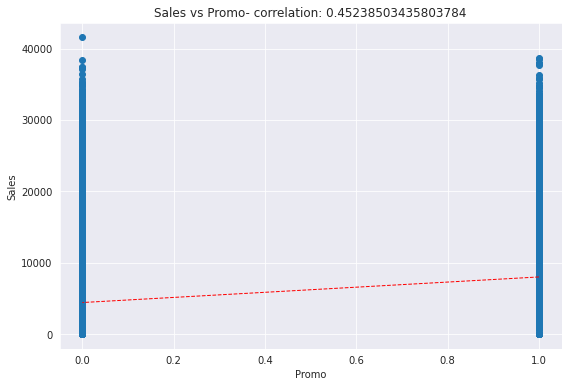

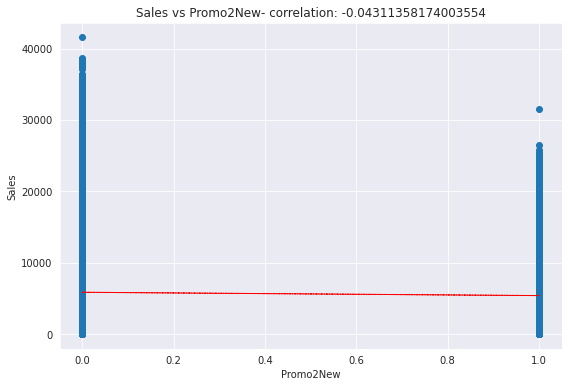

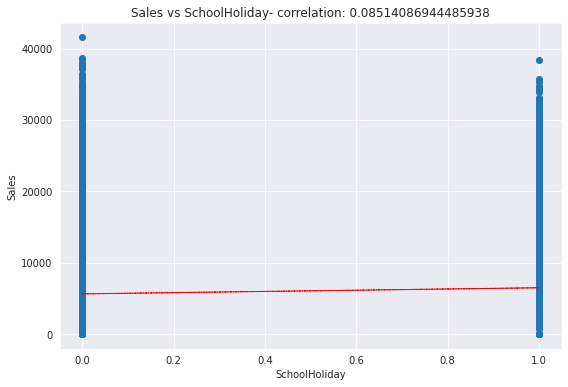

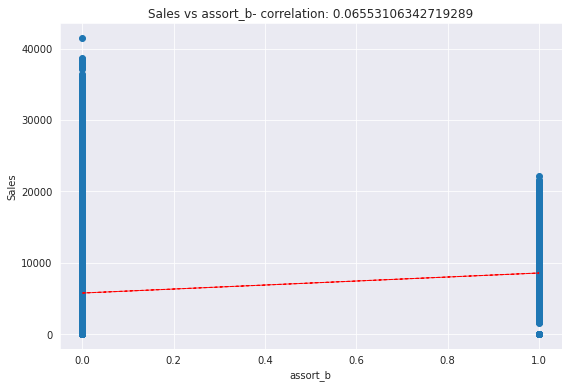

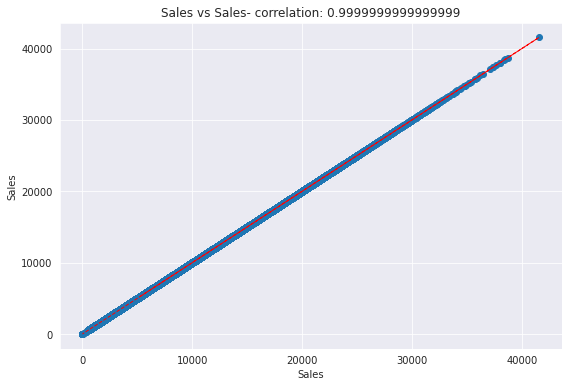

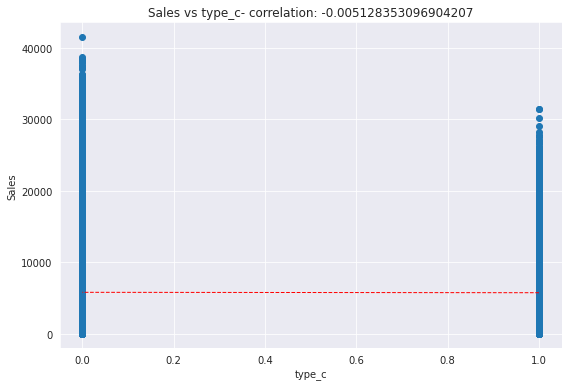

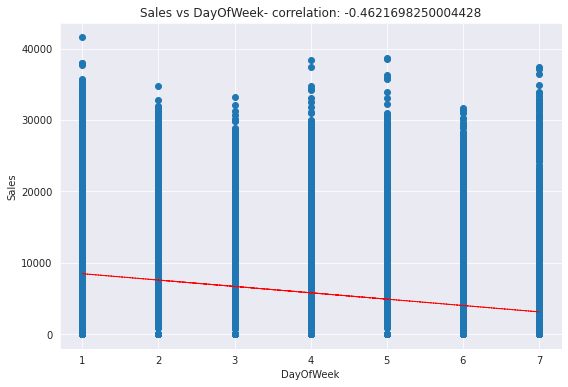

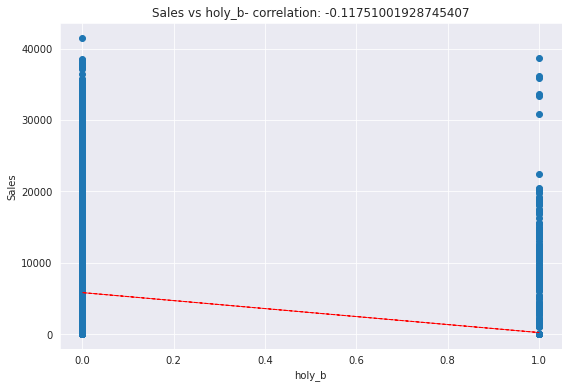

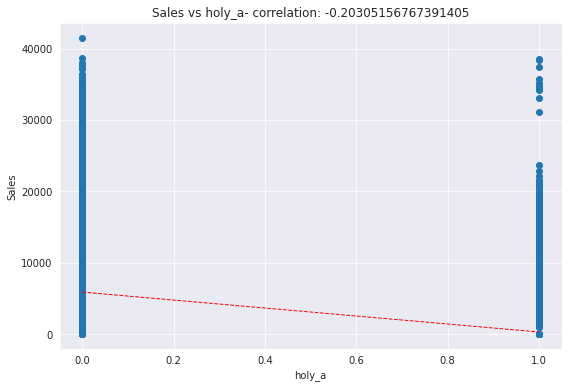

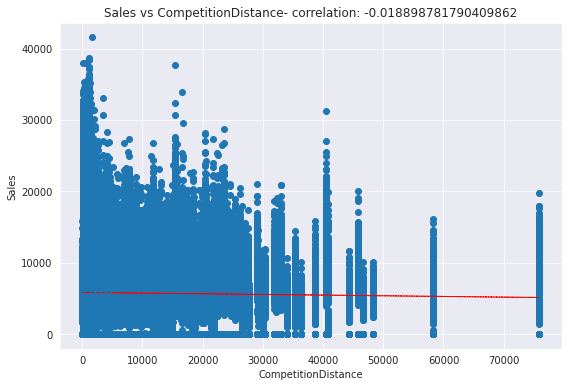

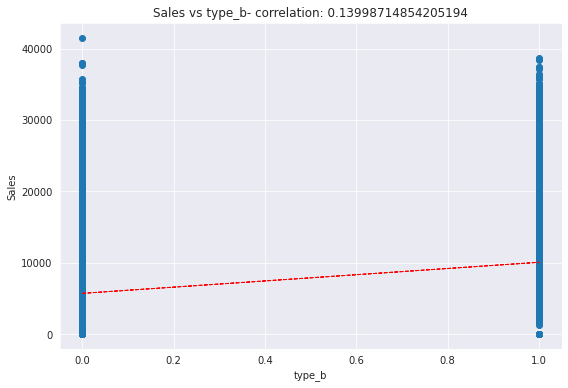

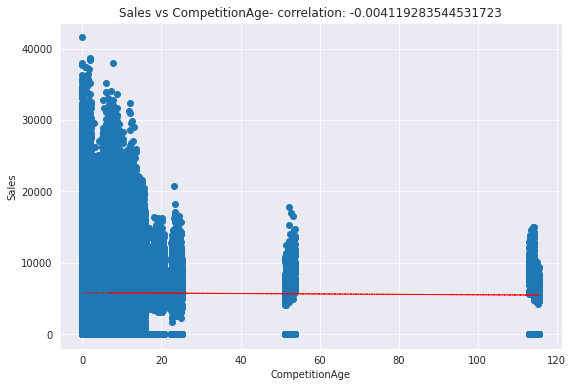

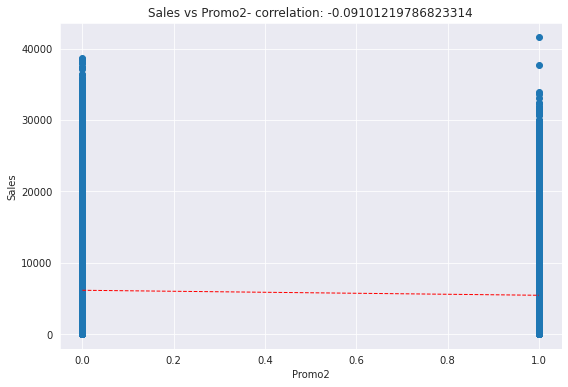

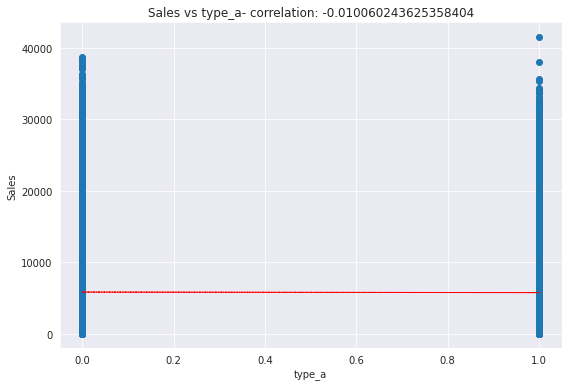

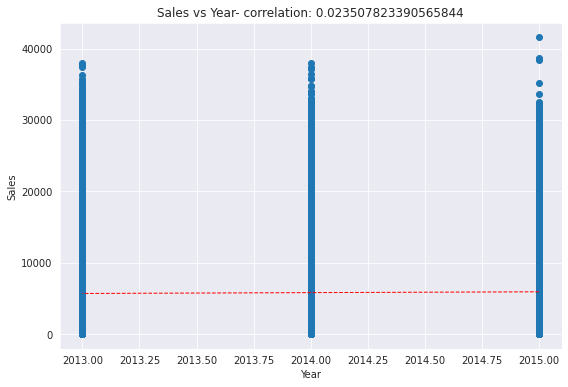

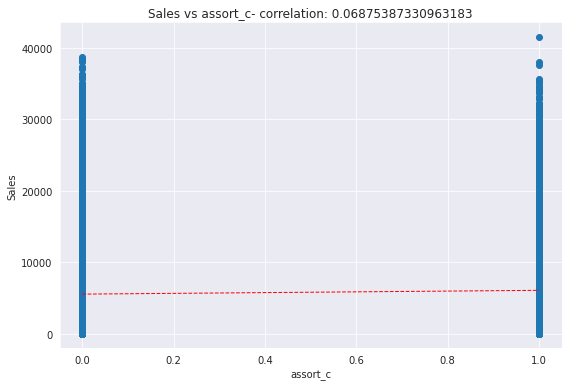

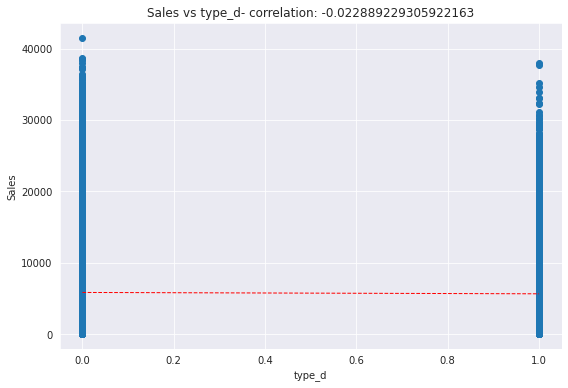

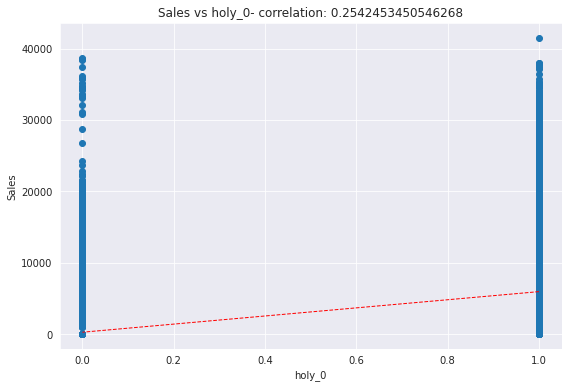

In [ ]:
# Correlation
for col in df1_open[all_features]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df1[col]
    label = df1['Sales']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Sales')
    ax.set_title('Sales vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(df1[col], df1['Sales'], 1)
    y_hat = np.poly1d(z)(df1[col])

    plt.plot(df1[col], y_hat, "r--", lw=1)

plt.show()

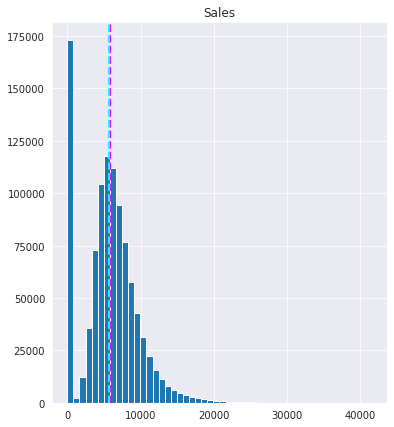

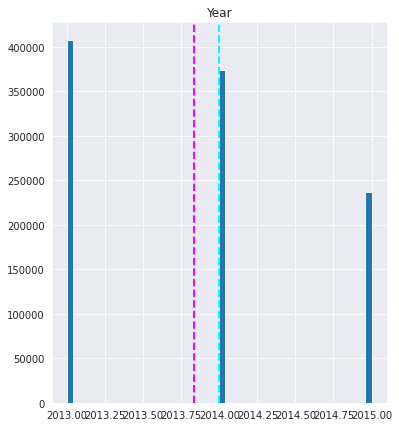

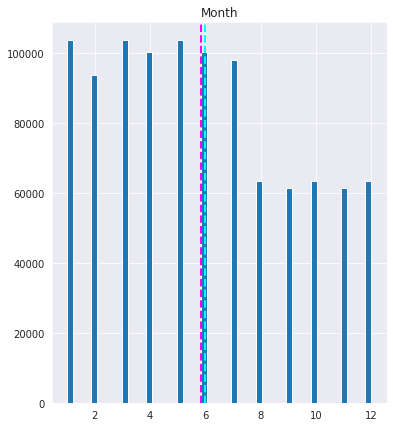

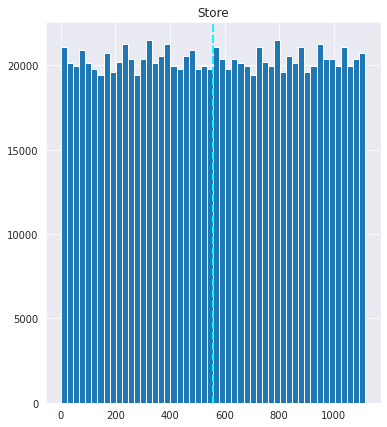

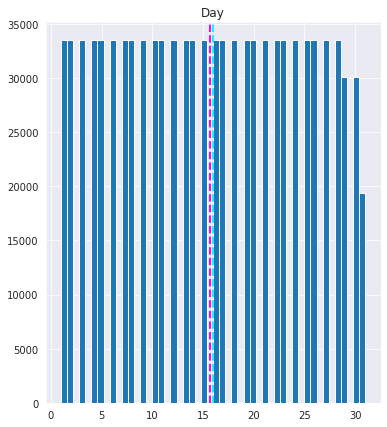

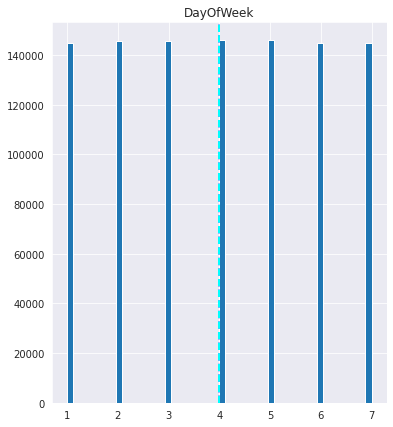

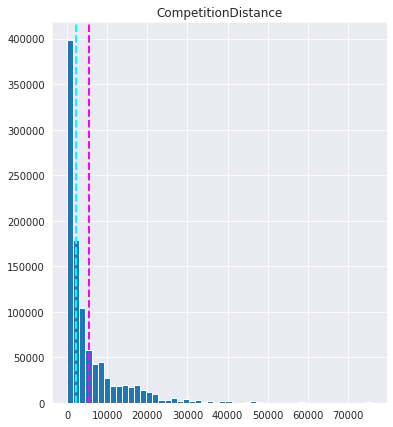

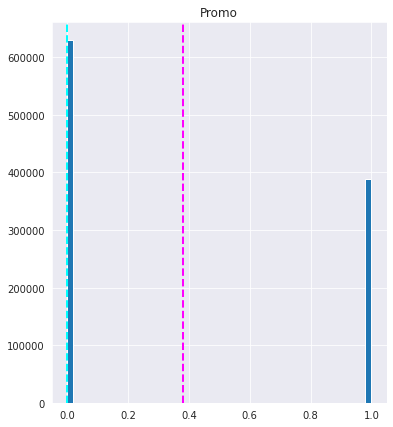

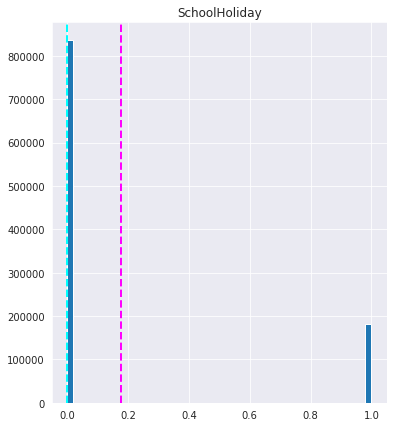

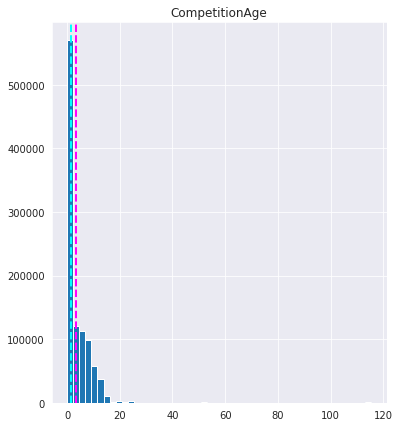

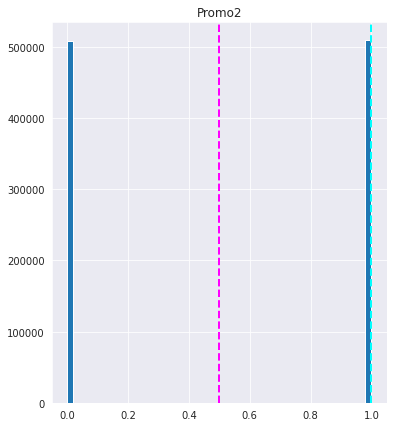

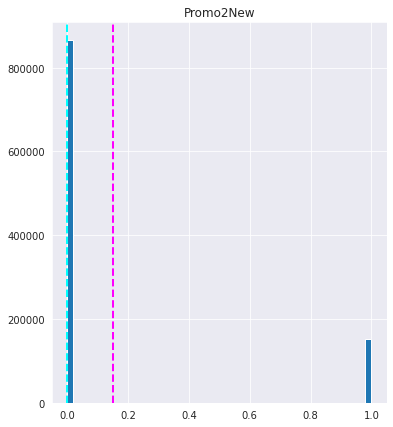

In [ ]:
# Distribustion
for col in df1_open[numerical_features]:
  figure=plt.figure(figsize=(6,7))
  ax=figure.gca()
  feature = df1[col]
  feature.hist(bins=50, ax = ax)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
  ax.set_title(col)
plt.show()

We need to remove multicollinearity and also normalise highly skewed features

In [ ]:
# Lets check vif to reduce multi collinearity
# We will not include 'open' as we are not training our model on it
# VIF
def get_vif(data):
  vif = pd.DataFrame()
  vif["variables"] = data.columns
  vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
  return vif

# calculating vif
get_vif(df1_open[numerical_features].drop(columns=['Sales']))

,variables,VIF
0,Year,20.595319
1,Month,4.159561
2,Store,4.015650
3,Day,4.407448
4,DayOfWeek,5.754970
5,CompetitionDistance,1.520089
6,Promo,2.005399
7,SchoolHoliday,1.285380
8,CompetitionAge,1.414933
9,Promo2,2.466071


In [ ]:
# Lets remove the 'year' feature 
get_vif(df1_open[numerical_features].drop(columns=['Sales','Year']))

,variables,VIF
0,Month,3.519131
1,Store,3.421325
2,Day,3.538007
3,DayOfWeek,3.935570
4,CompetitionDistance,1.460483
5,Promo,1.678441
6,SchoolHoliday,1.268428
7,CompetitionAge,1.386824
8,Promo2,2.337577
9,Promo2New,1.431451


Vif is less than 4 which is good enough

Sales 1.5949288357537479
CompetitionDistance 2.9800247527741837
CompetitionAge 7.548578716654258


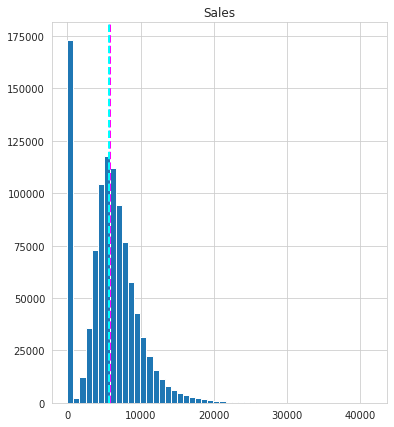

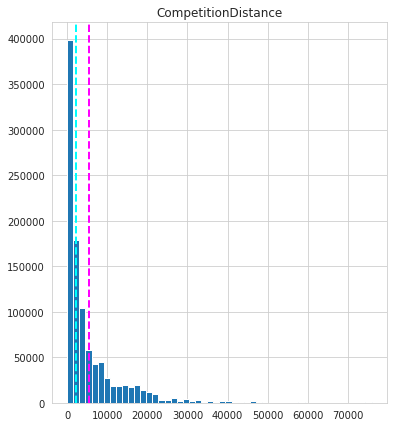

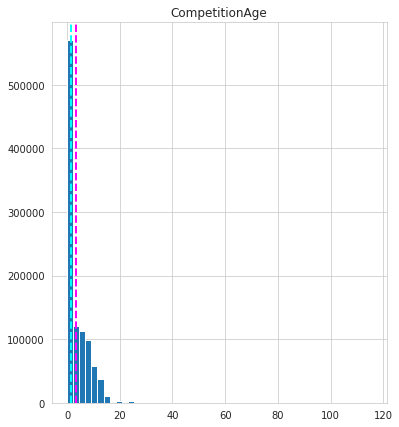

In [ ]:
# Lets use log10 transformation on highly skewed variables

# Only for when store is open 
# Before transformation
for col in ['Sales','CompetitionDistance','CompetitionAge']:
  
  print(col, df1_open[col].skew())
  figure=plt.figure(figsize=(6,7))
  ax=figure.gca()
  feature = df1[col]
  feature.hist(bins=50, ax = ax)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
  ax.set_title(col)
plt.show()



Sales_logt -0.10932694615873378
CompetitionDistance_logt -0.34862946056376687
CompetitionAge_logt 0.3568904661769419


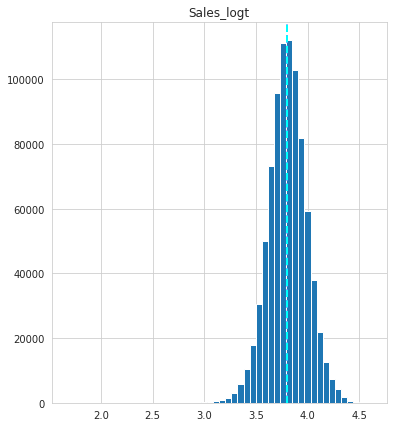

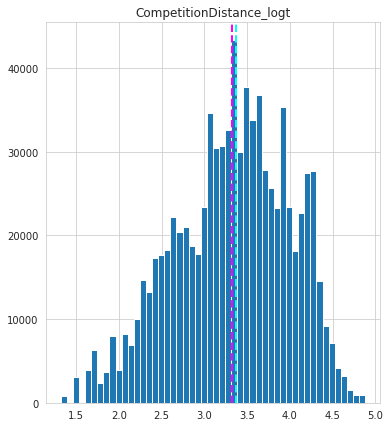

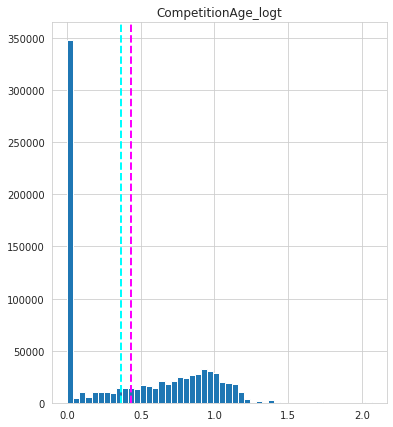

In [ ]:
# After transformation

df1_open['Sales_logt'] = df1_open['Sales'].apply(lambda x: np.log10(x+1))
df1_open['CompetitionDistance_logt'] = df1_open['CompetitionDistance'].apply(lambda x: np.log10(x+1))
df1_open['CompetitionAge_logt'] = df1_open['CompetitionAge'].apply(lambda x: np.log10(x+1))




for col in ['Sales_logt','CompetitionDistance_logt','CompetitionAge_logt']:
  # Checking skewness value only for non zero values
  print(col, df1_open[col].skew())
  figure=plt.figure(figsize=(6,7))
  ax=figure.gca()
  feature = df1_open[col]
  feature.hist(bins=50, ax = ax)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
  ax.set_title(col)
plt.show()

Skewness has reduced considerably,now our data is ready for training our model

In [ ]:
df1_open.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Day',
       'CompetitionAge', 'Promo2New', 'holy_0', 'holy_a', 'holy_b', 'holy_c',
       'type_a', 'type_b', 'type_c', 'type_d', 'assort_a', 'assort_b',
       'assort_c', 'Sales_logt', 'CompetitionDistance_logt',
       'CompetitionAge_logt'],
      dtype='object')

In [ ]:
df1_open_new = df1_open.drop(columns=['Store', 'DayOfWeek', 'Date', 'Sales', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Day',
       'CompetitionAge', 'Promo2New','holy_0', 'holy_a', 'holy_b', 'holy_c', 'type_a',
       'type_b', 'type_c', 'type_d', 'assort_a', 'assort_b', 'assort_c',])
df1_open_new.columns

Index(['Sales_logt', 'CompetitionDistance_logt', 'CompetitionAge_logt'], dtype='object')

In [ ]:
# Merging both dfs
new_df = pd.merge(df1,df1_open_new,how='left',left_index=True,right_index=True)
new_df.shape

(1017155, 28)

In [ ]:
new_df[new_df['Open']==0].head()

,Store,DayOfWeek,Date,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,Day,CompetitionAge,Promo2New,holy_0,holy_a,holy_b,holy_c,type_a,type_b,type_c,type_d,assort_a,assort_b,assort_c,Sales_logt,CompetitionDistance_logt,CompetitionAge_logt
291,292,5,2015-07-31,0,0,1,1,1100.0,0,2015,7,31,6.08,0,1,0,0,0,1,0,0,0,1,0,0,NaN,NaN,NaN
875,876,5,2015-07-31,0,0,1,1,21790.0,1,2015,7,31,10.25,0,1,0,0,0,1,0,0,0,1,0,0,NaN,NaN,NaN
1406,292,4,2015-07-30,0,0,1,1,1100.0,0,2015,7,30,6.08,0,1,0,0,0,1,0,0,0,1,0,0,NaN,NaN,NaN
1990,876,4,2015-07-30,0,0,1,1,21790.0,1,2015,7,30,10.25,0,1,0,0,0,1,0,0,0,1,0,0,NaN,NaN,NaN
2521,292,3,2015-07-29,0,0,1,1,1100.0,0,2015,7,29,6.08,0,1,0,0,0,1,0,0,0,1,0,0,NaN,NaN,NaN
